# Config

In [50]:
import os
import copy
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import warnings
warnings.simplefilter('ignore')

import utils
import evals
import model
import dataloader
import loss

import importlib
importlib.reload(utils)
importlib.reload(evals)
importlib.reload(model)
importlib.reload(loss)
importlib.reload(dataloader)

from utils import *
from evals import *
from model import *
from loss import *
from dataloader import *

In [5]:
import random
import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F

# リソースの指定（CPU/GPU）
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

# 乱数シード固定（再現性の担保）
def fix_seed(seed):
    # random
    random.seed(seed)
    # numpy
    np.random.seed(seed)
    # pytorch
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# seed を固定
seed = 42
fix_seed(seed)

# データローダーのサブプロセスの乱数seedが固定
def worker_init_fn(worker_id):
    np.random.seed(np.random.get_state()[1][0] + worker_id)

In [44]:
# API key
os.environ["OPENAI_API_KEY"] = "sk-xxx"

from langchain_openai import OpenAIEmbeddings
embedding_model = OpenAIEmbeddings(model = 'text-embedding-ada-002')

In [7]:
# !pip install graphviz
# !pip install torchview
# !pip install torchviz

# Data

<font size="4">**Dataset(Amebaブログのヘルプページ FAQ)**</font>

In [8]:
# 読み込み
df_qa = pd.read_csv("./dataset/Abema/QA.csv",index_col=0)
df_ref = pd.read_csv("./dataset/Abema/Reference.csv",index_col=0)
df_qa.shape,df_ref.shape

((2942, 4), (461, 2))

In [9]:
# 100問に限定
# df_qa_sub = df_qa.sample(100,random_state=0).sort_values("ID")
# df_qa.shape,df_ref.shape

In [10]:
# 学習,検証,テストデータ
from sklearn.model_selection import train_test_split
df_train, df_test  = train_test_split(df_qa, test_size=100, random_state=42, shuffle=True)
df_train, df_valid = train_test_split(df_train, test_size=100, random_state=42, shuffle=True)
df_train.shape,df_valid.shape,df_test.shape

((2742, 4), (100, 4), (100, 4))

In [11]:
df_qa.head(1)

,ID,Query,difficulty,dataset
0,faq_001,パスワードを忘れた,easy,train


<font size="4">**Text2Document**</font>

In [12]:
from langchain.schema.document import Document
documents = []
for i in range(len(df_ref)):
    data = df_ref.iloc[i]
    doc = Document(page_content=data["Reference"],metadata={"chunk_id":data["ID"]})
    documents.append(doc)
len(documents)

461

In [13]:
documents[0]

Document(page_content='Amebaで障害が発生している場合は、スタッフブログやX(旧Twitter)でお知らせします。\n該当の現象が障害に起因し発生しているかを、上記お知らせにてご確認ください。\n障害以外の理由で該当の事象が発生している場合は、以下の項目についてご確認・ご対応をお願いいたします。\nなお、記事投稿に失敗する際は、画面上にエラーが表示されるかと思いますのでご確認いただければと思います。\n１．推奨利用環境と端末・OSバージョンの確認をお願いします\nご利用の環境が推奨利用環境であるかをご確認の上、OSやアプリのアップデートをご検討ください。\n・Amebaアプリアプリのアップデート方法\n・利用しているOSの確認方法、アップデート方法\n・Amebaアプリのバージョン確認方法\n２．アプリのキャッシュ・データ削除と再起動をお願いします\nキャッシュとデータの削除を行うとアプリ保存記事（アプリ内に保存されている記事）は削除されます。「下書き（非公開）」または「公開」をした上で操作をお試しください。\n・アプリのキャッシュ・データの削除方法\n３．アプリの再インストールをお試しください\n再インストールをしても、退会手続きを行わない限りは同じアカウントでログインができます。 \n・アプリを再インストールする\n※Android 5.0未満をご利用の場合、あらたにAmebaアプリのインストールができません。\n※再インストールを行うとアプリ保存記事（アプリ内に保存されている記事）は削除されます。「下書き（非公開）」または「公開」をした上で操作をお試しください。', metadata={'chunk_id': 'faq_000'})

# Original FaissDB 

In [14]:
# DBの読み込み
faiss_db = FAISS.load_local("index/Abema/DB00-Original",embedding_model,allow_dangerous_deserialization=True)

In [16]:
# 評価
df_ret = execute_evaluation(faiss_db,df_test,DOC_NUM=len(df_ref))

  0%|                                                   | 0/100 [00:02<?, ?it/s]


KeyboardInterrupt: 

In [15]:
# 一覧
df_ret_table = pd.DataFrame({
    "Recall@1":[df_ret.recall_at_1],
    "Recall@3":[df_ret.recall_at_3],
    "Recall@5":[df_ret.recall_at_5],
    "Recall@10":[df_ret.recall_at_10],
    "Recall@20":[df_ret.recall_at_20],
    "Recall@30":[df_ret.recall_at_30],
    
})
df_ret_table

NameError: name 'df_ret' is not defined

# Dataset / DataLoader

### Dataset

In [16]:
# ベクトルの取り出し
vectors = get_vectors_from_FaissDB(faiss_db)
assert vectors.shape[0] == df_ref.shape[0]
len(vectors)

461

In [17]:
# チャンクIDとベクトルの辞書
doc_id_vec = {i:v for i,v in zip(df_ref.ID,vectors)}
len(doc_id_vec)

461

In [14]:
# クエリのベクトル化 (API消費)
# X_train = np.array(embedding_model.embed_documents(df_train["Query"]))
# X_valid = np.array(embedding_model.embed_documents(df_valid["Query"]))
# X_test  = np.array(embedding_model.embed_documents(df_test["Query"]))

In [ ]:
# 保存
# np.savez('./dataset/Abema/query_vectors_dataset',X_train,X_valid,X_test)

In [18]:
# 読み込み
npz = np.load('./dataset/Abema/query_vectors_dataset.npz')
# print(npz.files) # => ['arr_0', 'arr_1', 'arr_2']
X_train = npz["arr_0"]
X_valid = npz["arr_1"]
X_test  = npz["arr_2"]

In [19]:
# チャンクのベクトル
Y_train = np.array([doc_id_vec[k] for k in df_train["ID"].values])
Y_valid = np.array([doc_id_vec[k] for k in df_valid["ID"].values])
Y_test  = np.array([doc_id_vec[k] for k in df_test["ID"].values])

In [20]:
assert len(X_train)==len(Y_train)
assert len(X_valid)==len(Y_valid)
assert len(X_test)==len(Y_test)

### DataLoader

In [24]:
# NNモデル用
# dataset_train = EmbeddingVectorsDataset(X_train,Y_train,expand_dim=True)
# dataset_valid = EmbeddingVectorsDataset(X_valid,Y_valid,expand_dim=True)
# dataset_test  = EmbeddingVectorsDataset(X_test,Y_test,expand_dim=True)

# Convolutional Model用 (N,W)=>(N,D,W)
X_train_ = X_train.reshape(X_train.shape[0],-1,X_train.shape[1])
X_valid_ = X_valid.reshape(X_valid.shape[0],-1,X_valid.shape[1])
X_test_  = X_test.reshape(X_test.shape[0],-1,X_test.shape[1])

Y_train_ = Y_train.reshape(Y_train.shape[0],-1,Y_train.shape[1])
Y_valid_ = Y_valid.reshape(Y_valid.shape[0],-1,Y_valid.shape[1])
Y_test_  = Y_test.reshape(Y_test.shape[0],-1,Y_test.shape[1])

dataset_train_conv = EmbeddingVectorsDataset(X_train_,Y_train_)
dataset_valid_conv = EmbeddingVectorsDataset(X_valid_,Y_valid_)
dataset_test_conv  = EmbeddingVectorsDataset(X_test_,Y_test_)

In [25]:
from torch.utils.data import DataLoader

dataloader_train = DataLoader(
    dataset=dataset_train_conv,
    batch_size=64,
    shuffle=True,
    # num_workers=2,   # 高速化
    # pin_memory=True, # 高速化
    # worker_init_fn=worker_init_fn
)

dataloader_valid = DataLoader(
    dataset=dataset_valid_conv,
    batch_size=64,
    shuffle=True
)

dataloader_test = DataLoader(
    dataset=dataset_test_conv,
    batch_size=64,
    shuffle=True
)

# Model

**参考**
- https://qiita.com/takubb/items/7d45ae701390912c7629
- https://dacon.io/en/codeshare/5508

In [26]:
# PyTorch：(N, C, H, W)
adapter = Conv1dAutoencoder().to(device)
# 推論時は単一データの予測を行うため、BatchNormは利用しないモデルとしている。

In [28]:
# Model summary
from torchinfo import summary
summary(adapter, input_size=(32,1,1536))

Layer (type:depth-idx)                   Output Shape              Param #
Conv1dAutoencoder                        [32, 1, 1536]             --
├─Sequential: 1-1                        [32, 128, 144]            --
│    └─Conv1d: 2-1                       [32, 64, 492]             4,160
│    └─ReLU: 2-2                         [32, 64, 492]             --
│    └─Conv1d: 2-3                       [32, 128, 144]            524,416
│    └─ReLU: 2-4                         [32, 128, 144]            --
├─Sequential: 1-2                        [32, 1, 1536]             --
│    └─ConvTranspose1d: 2-5              [32, 64, 492]             524,352
│    └─ReLU: 2-6                         [32, 64, 492]             --
│    └─ConvTranspose1d: 2-7              [32, 1, 1536]             4,097
Total params: 1,057,025
Trainable params: 1,057,025
Non-trainable params: 0
Total mult-adds (G): 10.94
Input size (MB): 0.20
Forward/backward pass size (MB): 21.23
Params size (MB): 4.23
Estimated Total Size (

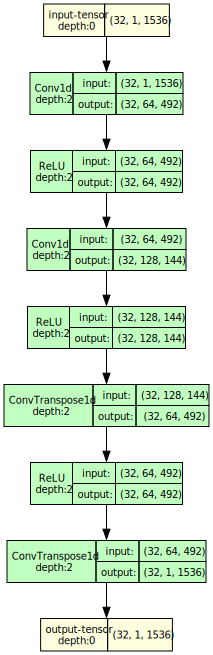

In [29]:
from torchview import draw_graph
model_graph = draw_graph(adapter, input_size=(32,1,1536))
model_graph.visual_graph

# Loss

In [32]:
# Loss Fucntion
# criteria_loss = nn.MSELoss()
# criteria_loss = nn.BCEWithLogitsLoss()
criteria_loss = Weighted_Loss(alpha=0.8)

# Evaluation Metrics
criteria_eval = nn.CosineEmbeddingLoss(margin=0)

# Train

In [33]:
from torch.optim.lr_scheduler import CosineAnnealingLR,StepLR,ReduceLROnPlateau

# Optimizer
# optimizer = optim.SGD(adapter.parameters(), lr=0.001)
# optimizer = optim.Adam(adapter.parameters(), lr=0.001)
optimizer = optim.Adam(adapter.parameters(), lr=0.001, weight_decay=1e-5)

# Callbacks
# scheduler = ReduceLROnPlateau(optimizer, 'min', patience=10, factor=0.8, min_lr=1e-8) # Using ReduceLROnPlateau schedule

In [34]:
# モデル訓練関数
def train(model, train_loader):
    
    # Train loop ----------------------------
    model.train()
    train_batch_loss = []
    train_batch_eval = []
    # avg_loss = 0.
    for x, y in train_loader:
        # GPUへの転送
        x, y = x.to(device), y.to(device)
        
        # 1. 勾配リセット
        optimizer.zero_grad()
        # 2. 推論
        output = model(x)
        # 3. 誤差計算
        loss   = criteria_loss(output, y)
        # metric = criteria_eval(output,y,torch.ones(output.shape[0]))
        metric = criteria_eval(output.squeeze(1),y.squeeze(1),torch.ones(output.shape[0]))
        # 4. 誤差逆伝播
        loss.backward()
        # 5. パラメータ更新
        optimizer.step()
        # train_lossの取得
        train_batch_loss.append(loss.item())
        train_batch_eval.append(metric.item())
        # avg_loss += loss.item()/len(train_loader)
    
    # scheduler更新
    # scheduler.step(np.mean(train_batch_loss))
        
    return model, np.mean(train_batch_loss), np.mean(train_batch_eval)

In [36]:
def validate(model, test_loader):
    # Test(val) loop ----------------------------
    model.eval()  # 学習モードをオフ
    test_batch_loss = []
    test_batch_eval = []
    with torch.no_grad():  # 勾配を計算なし
        for x, y in test_loader:
            x, y = x.to(device), y.to(device)
            output = model(x)
            loss   = criteria_loss(output, y)

            # For NN tensor shape
            # metric = criteria_eval(output,y,torch.ones(output.shape[0]))
            # For conv tensor shape
            metric = criteria_eval(output.squeeze(1),y.squeeze(1),torch.ones(output.shape[0]))
            
            test_batch_loss.append(loss.item())
            test_batch_eval.append(metric.item())
    return model, np.mean(test_batch_loss), np.mean(test_batch_eval)

In [37]:
def fit(model,epochs,dataloader_train,dataloader_valid):
    # 訓練の実行
    train_losses,train_metrics = [],[]
    valid_losses,valid_metrics = [],[]
    for epoch in range(epochs):
        model, train_loss, train_metric = train(model, dataloader_train)
        _    , valid_loss, valid_metric = validate(model, dataloader_valid)
        train_losses.append(train_loss)
        valid_losses.append(valid_loss)
        train_metrics.append(train_metric)
        valid_metrics.append(valid_metric)
        
        if epoch%1 == 0: #epochの表示間隔調整
            print(f'Epoch[{epoch+1}/{epochs}] train_loss: [{np.round(train_loss,6)}] metric: [{np.round(train_metric,3)}])')
            print(f'Epoch[{epoch+1}/{epochs}] valid_loss: [{np.round(valid_loss,6)}] metric: [{np.round(valid_metric,3)}])')
            print()
    # 学習履歴
    history = {
        "train":{"loss":train_losses,"metric":train_metrics},
        "valid":{"loss":valid_losses,"metric":valid_metrics}
    }
    return model,history

In [38]:
adapter,history = fit(
    adapter,
    epochs=2,
    dataloader_train=dataloader_train,
    dataloader_valid=dataloader_valid,
)

Epoch[1/2] train_loss: [0.086658] metric: [0.424])
Epoch[1/2] valid_loss: [0.031396] metric: [0.156])

Epoch[2/2] train_loss: [0.020963] metric: [0.104])
Epoch[2/2] valid_loss: [0.015196] metric: [0.075])



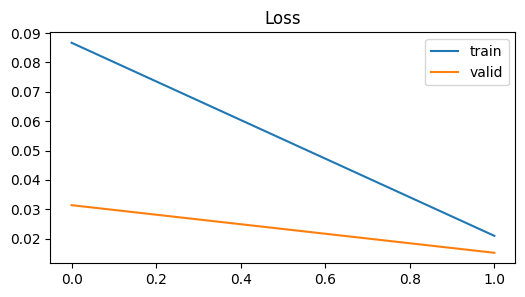

In [42]:
# 学習曲線 (損失関数値)
plt.figure(figsize=(6,3))#figsize=(8,6))
plt.plot(history["train"]["loss"],label='train')
plt.plot(history["valid"]["loss"],label='valid')
plt.title('Loss')
plt.xticks()#size=14)
plt.yticks()#size=14)
plt.legend()#fontsize=14)
plt.show()

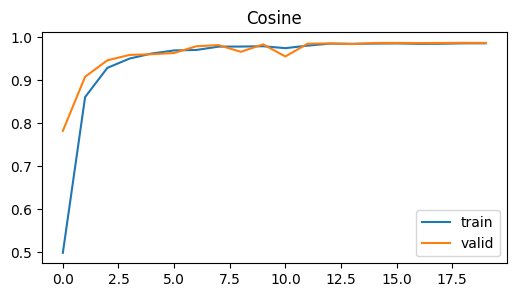

In [506]:
# 学習曲線 (精度)
plt.figure(figsize=(6,3))#figsize=(8,6))
plt.plot([1-v for v in history["train"]["metric"]],label='train')
plt.plot([1-v for v in history["valid"]["metric"]],label='valid')
plt.title('Cosine')
plt.xticks()#size=14)
plt.yticks()#size=14)
plt.legend()#fontsize=14)
plt.show()

# Attach the Adapter

In [51]:
# 推論モード
adapter.eval()

# Adapter付きモデル
embedding_adapter_model = OpenAIEmbeddingsWithAdapter(
    model = embedding_model,
    adapter = adapter
)

# Evaluation

In [52]:
# DBの読み込み
faiss_db = FAISS.load_local(
    "index/Abema/DB00-Original",
    embedding_adapter_model,
    allow_dangerous_deserialization=True
)

In [53]:
# 評価
df_ret_finetuned = execute_evaluation(faiss_db,df_test,DOC_NUM=len(df_ref))

100%|█████████████████████████████████████████| 100/100 [00:29<00:00,  3.35it/s]


In [54]:
# ConvAE_v2 + MSE & cosine
df_ret_finetuned_table = pd.DataFrame({
    "Recall@1":[df_ret_finetuned.recall_at_1],
    "Recall@3":[df_ret_finetuned.recall_at_3],
    "Recall@5":[df_ret_finetuned.recall_at_5],
    "Recall@10":[df_ret_finetuned.recall_at_10],
    "Recall@20":[df_ret_finetuned.recall_at_20],
    "Recall@30":[df_ret_finetuned.recall_at_30],
    
})
df_ret_finetuned_table

,Recall@1,Recall@3,Recall@5,Recall@10,Recall@20,Recall@30
0,0.28,0.47,0.53,0.69,0.79,0.84


In [434]:
# ConvAE + MSE & cosine
df_ret_finetuned_table = pd.DataFrame({
    "Recall@1":[df_ret_finetuned.recall_at_1],
    "Recall@3":[df_ret_finetuned.recall_at_3],
    "Recall@5":[df_ret_finetuned.recall_at_5],
    "Recall@10":[df_ret_finetuned.recall_at_10],
    "Recall@20":[df_ret_finetuned.recall_at_20],
    "Recall@30":[df_ret_finetuned.recall_at_30],
    
})
df_ret_finetuned_table

,Recall@1,Recall@3,Recall@5,Recall@10,Recall@20,Recall@30
0,0.42,0.64,0.7,0.86,0.91,0.93


In [55]:
# 学習済みモデルの保存・ロード
path_saved_model = "./adapter_Conv1dAutoencoder"

# モデルの保存
torch.save(adapter.state_dict(), path_saved_model)

# モデルのロード
# adapter = Conv1dAutoencoder().to(device)
# adapter.load_state_dict(torch.load(path_saved_model))

<All keys matched successfully>